# Exploring images as Zarr arrays

In this example, we'll see how we can access data from images in OME-NGFF format, in which values arestored as Zarr arrays. We'll visualise the data, and build an animated seasonal decoration.

First we need to load some libraries:

In [1]:
from ome_zarr.io import parse_url
from ome_zarr.reader import Reader

from bia_explorer.utils import scale_to_uint8

from PIL import Image, ImageOps

## Getting data

Next we'll import the BioImage Archive explorer library:

In [2]:
from bia_explorer.io import load_full_bia_study

Then we'll load a particular image from a study:

In [3]:
study = load_full_bia_study("S-BIAD582")

image = study.images["IM1754"]

Now we can see which arrays are in the image:

In [5]:
store = parse_url(image.representations[1].uri, mode="r").store

reader = Reader(parse_url(image.representations[1].uri))
# nodes may include images, labels etc
nodes = list(reader())
# first node will be the image pixel data
image_node = nodes[0]

Our data have different resolutions, so we see multiple arrays:

In [6]:
image_node.data

[dask.array<from-zarr, shape=(1, 5, 1, 485, 1091), dtype=>u2, chunksize=(1, 1, 1, 485, 1024), chunktype=numpy.ndarray>,
 dask.array<from-zarr, shape=(1, 5, 1, 242, 545), dtype=>u2, chunksize=(1, 1, 1, 242, 545), chunktype=numpy.ndarray>,
 dask.array<from-zarr, shape=(1, 5, 1, 121, 272), dtype=>u2, chunksize=(1, 1, 1, 121, 272), chunktype=numpy.ndarray>,
 dask.array<from-zarr, shape=(1, 5, 1, 60, 136), dtype=>u2, chunksize=(1, 1, 1, 60, 136), chunktype=numpy.ndarray>]

We'll take the first of these:

In [7]:
highest_res = image_node.data[0]

This is an image with 5 channels:

In [8]:
highest_res

dask.array<from-zarr, shape=(1, 5, 1, 485, 1091), dtype=>u2, chunksize=(1, 1, 1, 485, 1024), chunktype=numpy.ndarray>

## Displaying images

To render this as an image, we first need to select a single plane and compute it (transform it from a lazy array to an in-memory array):

In [9]:
single_channel = highest_res[0,0,0,:,:].compute()

then we can render the result as a PIL image (though we need to scale it to be an unsigned 8 bit array first):

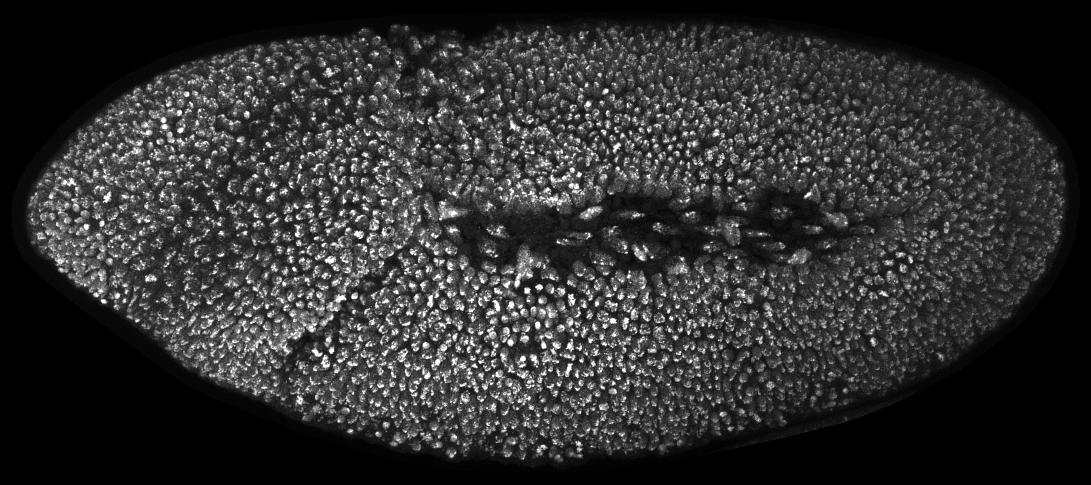

In [10]:
pil_im = Image.fromarray(scale_to_uint8(single_channel))
pil_im

If we want to display a coloured image, we can use the Pillow library's ImageOps functions:

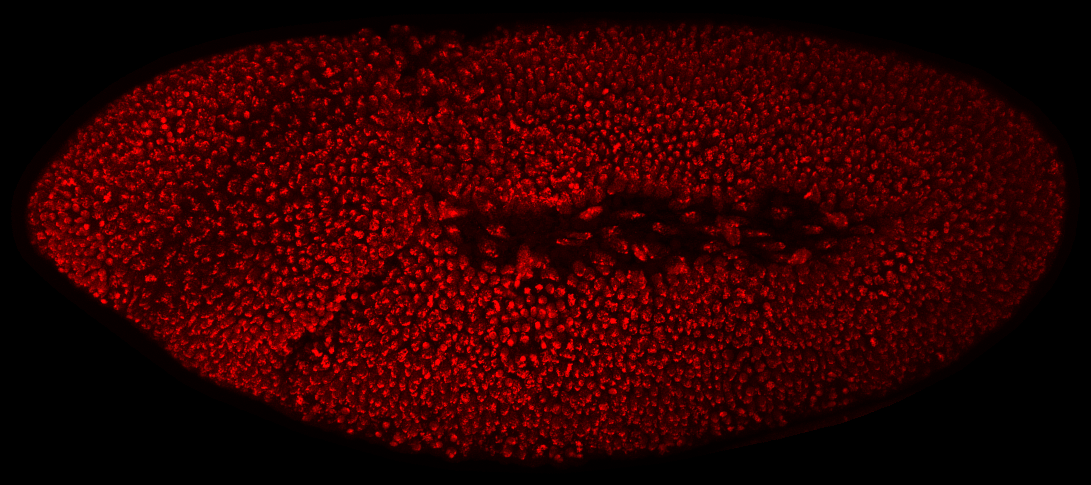

In [11]:
ImageOps.colorize(pil_im, black="black", white="red")

To colour different channels, we'll define a map to assign colours to channels:

In [12]:
colors = ["blue", "red", "green", "cyan", "yellow"]

color_map = {
    n: c
    for n, c in enumerate(colors)
}

Then we can create a function to load each channel as separate image and colourise them:

In [13]:
def c_to_color_image(c):
    single_channel = highest_res[0,c,0,:,:].compute()
    grayscale = scale_to_uint8(single_channel)
    gim = Image.fromarray(grayscale).convert("L")
    im = ImageOps.colorize(gim, black="black", white=color_map[c])
    return im

channel_images = [c_to_color_image(c) for c in range(5)]

Then we can save the result as an animated GIF:

In [14]:
channel_images[1].save("blinky.gif", format="GIF", append_images=channel_images[2:], save_all=True, duration=250, loop=0)

and finally, load and view the result:

In [15]:
from IPython.display import Image as ipyImage

with open("blinky.gif", "rb") as fh:
    im = ipyImage(data=fh.read())

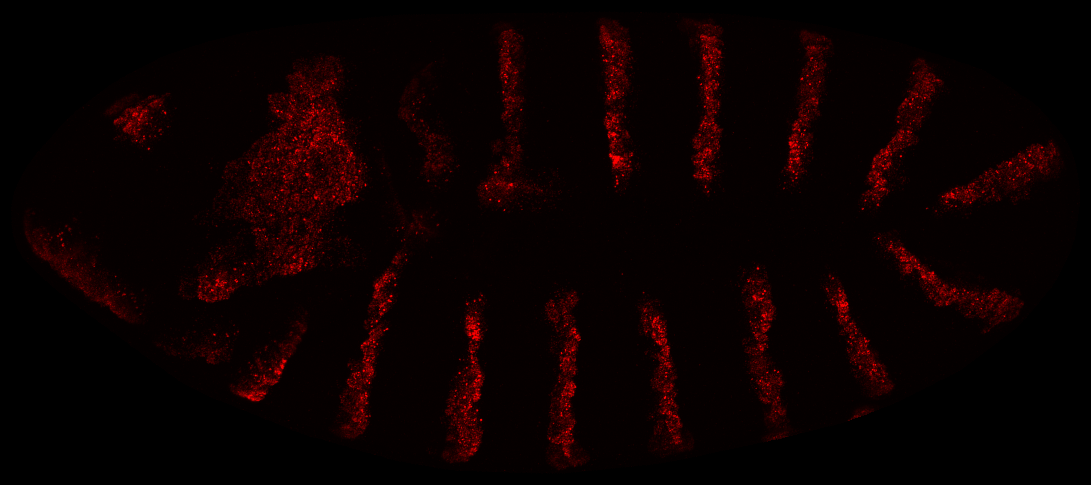

In [16]:
im